# YouTube Dislikes predictions

This notebook contains code to:
- read data saved using data_transformations.ipynb
- train a neural network to predict the number of dislikes

## Imports

In [1]:
import pickle

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import plot_model

In [2]:
if not tf.test.is_gpu_available:
    print('GPU is not available. Training will be extremely slow')

## Load data saved in `data_trasformations` notebook

In [3]:
save_folder = 'models/data'

In [4]:
y_train = np.load(f'{save_folder}/y_train.npy')
y_test = np.load(f'{save_folder}/y_test.npy')

numeric_data_train = np.load(f'{save_folder}/numeric_data_train.npy')
numeric_data_test = np.load(f'{save_folder}/numeric_data_test.npy')

In [5]:
author_text_data_train = pickle.load(
    open(f'{save_folder}/author_text_data_train.p', 'rb'))
author_text_data_test = pickle.load(
    open(f'{save_folder}/author_text_data_test.p', 'rb'))

comments_data_train = pickle.load(
    open(f'{save_folder}/comments_data_train.p', 'rb'))
comments_data_test = pickle.load(
    open(f'{save_folder}/comments_data_test.p', 'rb'))

In [6]:
embeddings_1 = pickle.load(open(f'{save_folder}/embeddings_1.p', 'rb'))
embeddings_2 = pickle.load(open(f'{save_folder}/embeddings_2.p', 'rb'))

# Model

## Model architecture

In [7]:
def LSTM_and_skip_connection(inputs):
    """ 
    Network block with 64-unit LSTM, skip connection and layer normalization.
    Inputs and outputs tensor of shape (None, None, 128)
    """
    
    text_features = layers.Bidirectional(
            layers.LSTM(64, return_sequences=True))(inputs)
    text_features = layers.Add()([text_features, inputs])
    output = layers.LayerNormalization()(text_features)
    
    return output

In [8]:
def model():

    # variable-length input for author_text
    text_1_input = keras.Input(shape=(None,), name="author_text_input")

    # variable-length input for comments
    text_2_input = keras.Input(shape=(None,), name="comments_input")

    # 3 vectors of numbers
    numbers_input = keras.Input(shape=(3,), name="numbers_input")

    # using pretrained embeddings
    text_1_features = embeddings_1(text_1_input)
    text_2_features = embeddings_2(text_2_input)
    
    # text_1_features = layers.Embedding(350, 300)(text_1_input)
    # text_2_features = layers.Embedding(750, 300)(text_2_input)

    # processing author_text
    text_1_features_1 = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True))(text_1_features)
    text_1_features = LSTM_and_skip_connection(text_1_features_1)
    # uncomment to use more blocks
    # text_1_features = LSTM_and_skip_connection(text_1_features)
    # ... 
    
    text_1_features = layers.Bidirectional(layers.LSTM(32))(text_1_features)

    # processing comments
    text_2_features_1 = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True))(text_2_features)
    text_2_features = LSTM_and_skip_connection(text_2_features_1)
    text_2_features = layers.Bidirectional(layers.LSTM(32))(text_2_features)

    # merge all available features into a single large vector
    concat = layers.concatenate(
        [text_1_features, text_2_features, numbers_input], name='concat')

    # final part of the model
    dense_1 = layers.Dense(64, activation='relu',
                           name='dense_64')(concat)
    dropout_1 = layers.Dropout(0.2, name='dropout_1')(dense_1)
    dense_2 = layers.Dense(32, activation='relu',
                           name='dense_32')(dropout_1)
    dropout_2 = layers.Dropout(0.2, name='dropout_2')(dense_2)
    output = layers.Dense(1, activation='relu', name='output')(dropout_2)

    model = keras.Model(inputs=[text_1_input, text_2_input, numbers_input],
                        outputs=output,
                        name="dislikes_predictor")

    return model

Model: "dislikes_predictor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 author_text_input (InputLayer)  [(None, None)]      0           []                               
                                                                                                  
 comments_input (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 pretrained_embeddings_for_auth  (None, None, 300)   3000000     ['author_text_input[0][0]']      
 or_text (Embedding)                                                                              
                                                                                                  
 pretrained_embeddings_for_comm  (None, None, 300)   3000000     ['comments_input

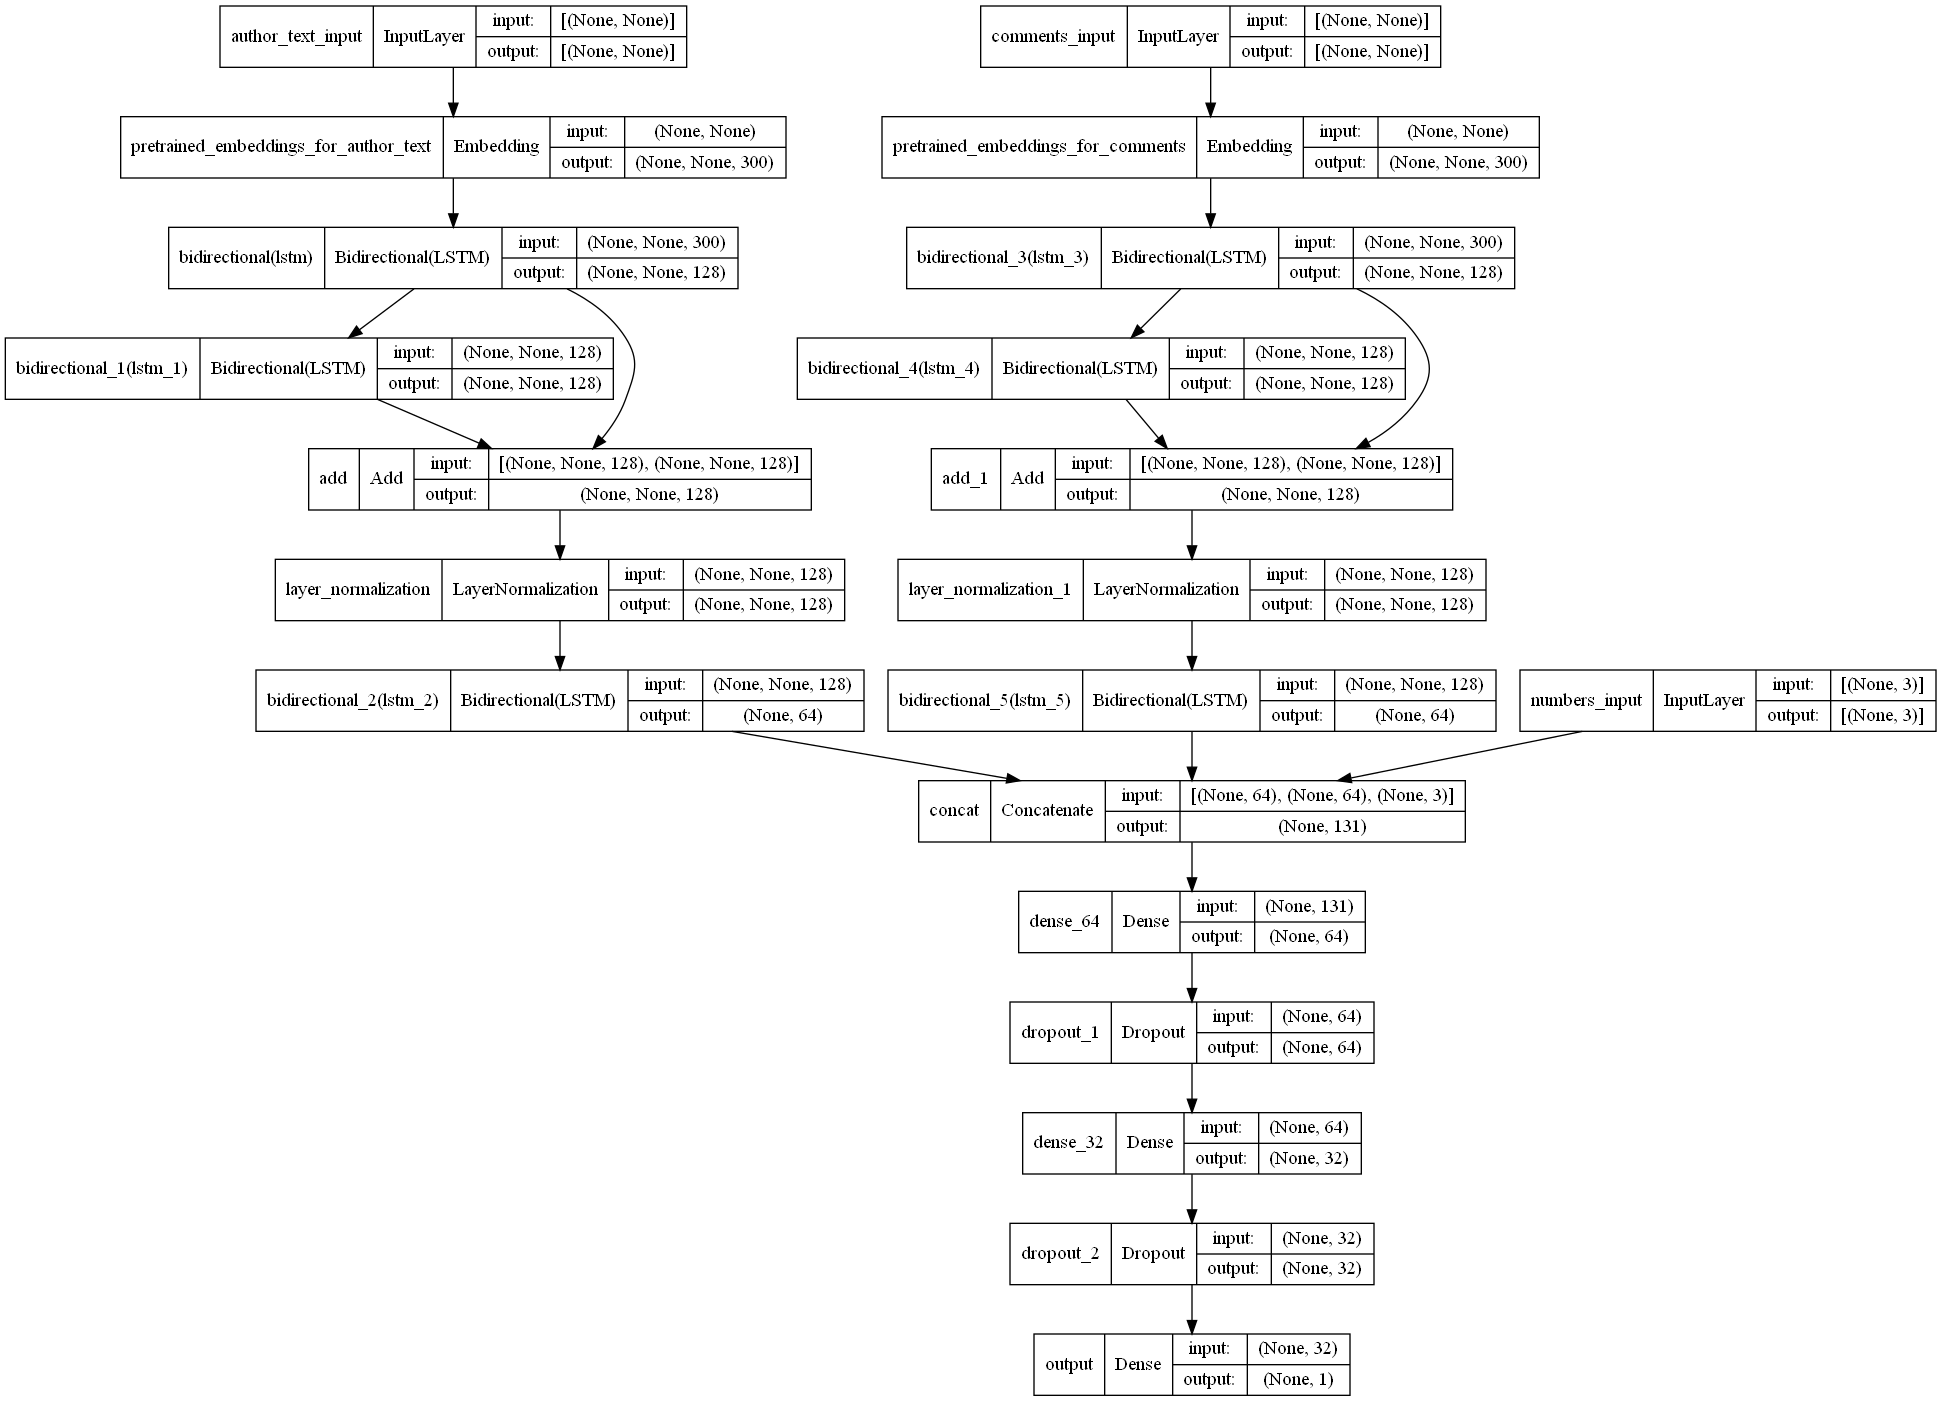

In [9]:
model = model()

# summarize layers
print(model.summary())
# plot model architecture
plot_model(model, show_shapes=True,
           to_file='article/img/NN_architecture_plot_model.png')

## Compile and train a model

In [10]:
# X_train in a form understandable to the network
train_data = {"author_text_input": author_text_data_train,
              "comments_input": comments_data_train,
              "numbers_input": numeric_data_train}

# X_test
test_data = {"author_text_input": author_text_data_test,
              "comments_input": comments_data_test,
              "numbers_input": numeric_data_test}

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=['mae', 'mse']
)

In [12]:
model_name_to_save = 'model_fastText_11'

In [13]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = keras.callbacks.ModelCheckpoint(
    f"models/{model_name_to_save}.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1)

callbacks = [checkpoint]

In [14]:
history = model.fit(x=[author_text_data_train,
                       comments_data_train,
                       numeric_data_train],
                    y=y_train,
                    epochs=1,
                    batch_size=128,
                    callbacks=callbacks,
                    validation_split=0.2)

model.save(f"models/{model_name_to_save}.h5")

93/93 [==============================] - ETA: 0s - loss: 1135061632.0000 - mae: 6359.0376 - mse: 1135061632.0000
Epoch 00001: val_loss improved from inf to 1260867584.00000, saving model to models\model_fastText_11.h5


C:\Users\dmytro\anaconda3\envs\tenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


93/93 [==============================] - 57s 472ms/step - loss: 1135061632.0000 - mae: 6359.0376 - mse: 1135061632.0000 - val_loss: 1260867584.0000 - val_mae: 6200.0918 - val_mse: 1260867584.0000


In [16]:
# model.evaluate(test_data, y_test, batch_size=128)